In [1]:
import numpy as np
import cvxpy as cp
from scipy.interpolate import BSpline
from patsy import dmatrix
from scipy.optimize import minimize
from nldg.utils import max_mse, min_xplvar, gen_data_v2, gen_data_v3, gen_data_v4, gen_data_v5
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_setting = 4
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=1000, n_hard=1000)
else:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [3]:
def bspline_N(x, knots, degree):
    """
    Evaluate the B-spline basis at points x.
    Returns a design matrix of shape (len(x), M) where M = len(knots) - degree - 1.
    """
    x = np.atleast_1d(x).flatten()
    M = len(knots) - degree - 1
    X_design = np.zeros((len(x), M))
    for i in range(M):
        # Basis function: set coefficient 1 for the i-th basis, 0 otherwise.
        c = np.zeros(M)
        c[i] = 1
        spl = BSpline(knots, c, degree, extrapolate=False)
        X_design[:, i] = spl(x)
    return X_design

def bspline_2der(x, knots, degree, i):
    """
    Evaluate the second derivative of the i-th B-spline basis function at x.
    """
    x = np.atleast_1d(x).flatten()
    M = len(knots) - degree - 1
    c = np.zeros(M)
    c[i] = 1
    spl = BSpline(knots, c, degree, extrapolate=False)
    spl2 = spl.derivative(nu=2)
    return spl2(x)

def omega(knots, degree, grid_points):
    """
    Compute Omega[i,j] = \int [B_i''(x) B_j''(x)] dx by numerical integration.
    """
    M = len(knots) - degree - 1
    Omega = np.zeros((M, M))
    dx = grid_points[1] - grid_points[0]  # assume uniform grid spacing
    for i in range(M):
        Bi2 = bspline_2der(grid_points, knots, degree, i)
        for j in range(M):
            Bj2 = bspline_2der(grid_points, knots, degree, j)
            Omega[i, j] = np.sum(Bi2 * Bj2) * dx
    return Omega

## Minimizing the maximum MSE over training environments

In [4]:
x_min = dtr["X"].min()
x_max = dtr["X"].max()

degree = 3  # cubic splines
n_bases = 10  # number of basis functions

n_internal = n_bases - degree + 1  # number of internal knots
internal_knots = np.linspace(x_min, x_max, n_internal)
knots = np.concatenate((np.repeat(x_min, degree), internal_knots, np.repeat(x_max, degree)))
M = len(knots) - degree - 1

# Compute the penalty matrix using a fine grid over the domain.
grid = np.linspace(x_min, x_max, 400)
Omega = omega(knots, degree, grid)

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

N0 = bspline_N(Xtr[mask_env0], knots, degree)
N1 = bspline_N(Xtr[mask_env1], knots, degree)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

N = bspline_N(Xtr, knots, degree)
Y_pooled = Ytr

_lambda = 0.01

# Classical solution
beta = cp.Variable(M)
objective = cp.Minimize(
    cp.mean(cp.square(Y_pooled - N @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
beta_maximin = cp.Variable(M)
t = cp.Variable(nonneg=True)

constraints = []
constraints.append(cp.mean(cp.square(Y_env0 - N0 @ beta_maximin)) <= t)
constraints.append(cp.mean(cp.square(Y_env1 - N1 @ beta_maximin))<= t)

if data_setting == 2:
    mask_env2 = (Etr == 2)
    N2 = bspline_N(Xtr[mask_env2], knots, degree)
    Y_env2 = Ytr[mask_env2]
    constraints.append(cp.mean(cp.square(Y_env2 - N2 @ beta_maximin)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve()

# Predictions
x_grid = np.linspace(x_min, x_max, 200)
X_grid = bspline_N(x_grid, knots, degree)

y_pred_traditional = X_grid @ beta.value
y_pred_maximin_mse = X_grid @ beta_maximin.value

In [5]:
# Magging
def obj_magging(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    N_e = bspline_N(Xtr_e, knots, degree)

    beta_e = cp.Variable(M)
    objective = cp.Minimize(
        cp.mean(cp.square(Ytr_e - N_e @ beta_e)) +
        _lambda * cp.quad_form(beta_e, Omega)
    )
    problem = cp.Problem(objective)
    problem.solve()

    preds_envs.append(X_grid @ beta_e.value)
    fitted_envs.append(N @ beta_e.value)

preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)
wmag = minimize(obj_magging, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
y_pred_magging = np.dot(wmag, preds_envs.T)
fitted_magging = np.dot(wmag, fitted_envs.T)
#n = Xtr.shape[0]
#Gamma = fitted_envs.T @ fitted_envs / n
#q = cp.Variable(n_envs, nonneg=True)
#constraints = [cp.sum(q) == 1]
#objective = cp.Minimize(cp.quad_form(q, Gamma))
#prob = cp.Problem(objective, constraints)
#prob.solve()
#q.value

In [6]:
wmag

array([0.80397555, 0.19602445])

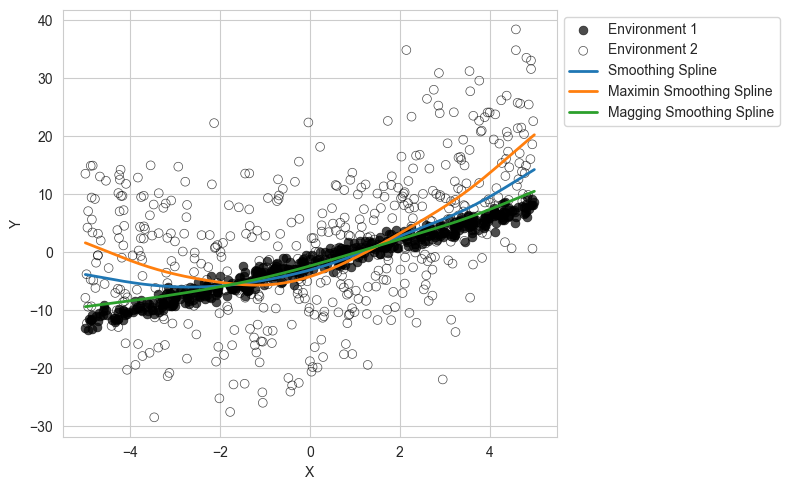

In [7]:
plt.figure(figsize=(8, 5))

scatter1 = sns.scatterplot(
    x=dtr[dtr["E"] == 0]["X"], y=dtr[dtr["E"] == 0]["Y"],
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment 1",
    marker="o"
)

sns.scatterplot(
    x=dtr[dtr["E"] == 1]["X"], y=dtr[dtr["E"] == 1]["Y"],
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment 2",
    marker="o"
)

if data_setting == 2:
    sns.scatterplot(
        data=dtr[dtr["E"] == dtr["E"].unique()[2]],
        x="X", y="Y",
        facecolors="none", edgecolor="black",
        s=40, alpha=0.7, label="Environment 3",
        marker="D"
    )

line1, = plt.plot(x_grid, y_pred_traditional, linewidth=2, label="Smoothing Spline")
line2, = plt.plot(x_grid, y_pred_maximin_mse, linewidth=2, label="Maximin Smoothing Spline")
line3, = plt.plot(x_grid, y_pred_magging, linewidth=2, label="Magging Smoothing Spline")

handles_scatter, labels_scatter = scatter1.get_legend_handles_labels()
method_handles = [line1, line2, line3]

plt.legend(handles=handles_scatter + method_handles, labels=labels_scatter,
           loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
fitted = N @ beta.value
max_mse(Ytr, fitted, Etr, verbose=True)

Environment 0 MSE: 9.226367627845702
Environment 1 MSE: 101.79019361273878


np.float64(101.79019361273878)

In [9]:
min_xplvar(Ytr, fitted, Etr, verbose=True)

Environment 0 explained variance: 26.173083600286496
Environment 1 explained variance: 45.72231961060125


np.float64(26.173083600286496)

In [10]:
fitted_maximin = N @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 MSE: 30.59612359943878
Environment 1 MSE: 94.37360228521199


np.float64(94.37360228521199)

In [11]:
min_xplvar(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 explained variance: 4.80332762869342
Environment 1 explained variance: 53.138910938128035


np.float64(4.80332762869342)

In [12]:
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 2.131904888505508
Environment 1 MSE: 116.26845601009714


np.float64(116.26845601009714)

In [13]:
min_xplvar(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 explained variance: 33.26754633962669
Environment 1 explained variance: 31.244057213242883


np.float64(31.244057213242883)

## Maximizing the minimal explained variance over training environments

In [210]:
x_min = dtr["X"].min()
x_max = dtr["X"].max()

degree = 3  # cubic splines
n_bases = 10  # number of basis functions

n_internal = n_bases - degree + 1  # number of internal knots
internal_knots = np.linspace(x_min, x_max, n_internal)
knots = np.concatenate((np.repeat(x_min, degree), internal_knots, np.repeat(x_max, degree)))
M = len(knots) - degree - 1

# Compute the penalty matrix using a fine grid over the domain.
grid = np.linspace(x_min, x_max, 400)
Omega = omega(knots, degree, grid)

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

N0 = bspline_N(Xtr[mask_env0], knots, degree)
N1 = bspline_N(Xtr[mask_env1], knots, degree)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

N = bspline_N(Xtr, knots, degree)
Y_pooled = Ytr

_lambda = 0.01

# Classical solution
beta = cp.Variable(M)
objective = cp.Minimize(
    cp.mean(cp.square(Y_pooled - N @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
beta_maximin = cp.Variable(M)
t = cp.Variable()

constraints = []
constraints.append(cp.mean(cp.square(Y_env0 - N0 @ beta_maximin)) - cp.mean(cp.square(Y_env0)) <= t)
constraints.append(cp.mean(cp.square(Y_env1 - N1 @ beta_maximin)) - cp.mean(cp.square(Y_env1)) <= t)

if data_setting == 2:
    mask_env2 = (Etr == 2)
    N2 = bspline_N(Xtr[mask_env2], knots, degree)
    Y_env2 = Ytr[mask_env2]
    constraints.append(cp.mean(cp.square(Y_env2 - N2 @ beta_maximin)) - cp.mean(cp.square(Y_env2)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve(solver=cp.SCS)

# Predictions
x_grid = np.linspace(x_min, x_max, 200)
X_grid = bspline_N(x_grid, knots, degree)

y_pred_traditional = X_grid @ beta.value
y_pred_maximin_ev = X_grid @ beta_maximin.value

In [211]:
# Magging
def obj_magging(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    N_e = bspline_N(Xtr_e, knots, degree)

    beta_e = cp.Variable(M)
    objective = cp.Minimize(
        cp.mean(cp.square(Ytr_e - N_e @ beta_e)) +
        _lambda * cp.quad_form(beta_e, Omega)
    )
    problem = cp.Problem(objective)
    problem.solve(solver=cp.SCS)

    preds_envs.append(X_grid @ beta_e.value)
    fitted_envs.append(N @ beta_e.value)

preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)
wmag = minimize(obj_magging, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
y_pred_magging = np.dot(wmag, preds_envs.T)
fitted_magging = np.dot(wmag, fitted_envs.T)

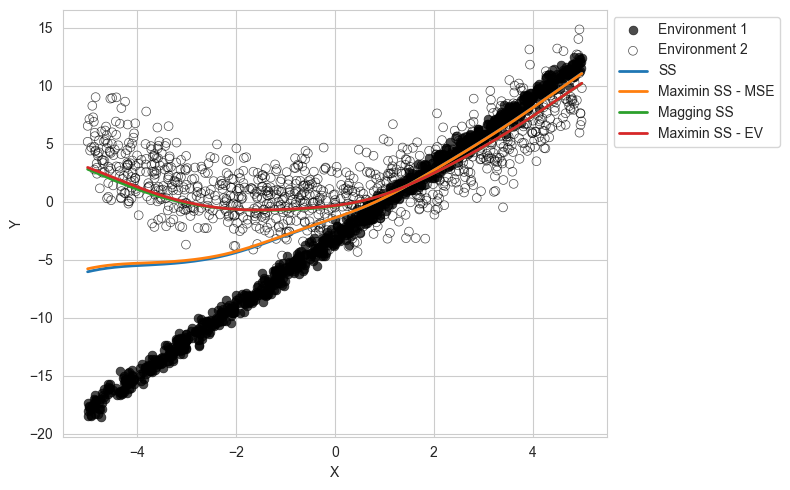

In [212]:
plt.figure(figsize=(8, 5))

scatter1 = sns.scatterplot(
    x=dtr[dtr["E"] == 0]["X"], y=dtr[dtr["E"] == 0]["Y"],
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment 1",
    marker="o"
)

sns.scatterplot(
    x=dtr[dtr["E"] == 1]["X"], y=dtr[dtr["E"] == 1]["Y"],
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment 2",
    marker="o"
)

if data_setting == 2:
    sns.scatterplot(
        data=dtr[dtr["E"] == dtr["E"].unique()[2]],
        x="X", y="Y",
        facecolors="none", edgecolor="black",
        s=40, alpha=0.7, label="Environment 3",
        marker="D"
    )

line1, = plt.plot(x_grid, y_pred_traditional, linewidth=2, label="SS")
line2, = plt.plot(x_grid, y_pred_maximin_mse, linewidth=2, label="Maximin SS - MSE")
line3, = plt.plot(x_grid, y_pred_magging, linewidth=2, label="Magging SS")
line4, = plt.plot(x_grid, y_pred_maximin_ev, linewidth=2, label="Maximin SS - EV")

handles_scatter, labels_scatter = scatter1.get_legend_handles_labels()
method_handles = [line1, line2, line3, line4]

plt.legend(handles=handles_scatter + method_handles, labels=labels_scatter,
           loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

In [213]:
fitted = N @ beta.value
max_mse(Ytr, fitted, Etr, verbose=True)

Environment 0 MSE: 22.001982961737472
Environment 1 MSE: 23.889622948230944


np.float64(23.889622948230944)

In [214]:
min_xplvar(Ytr, fitted, Etr, verbose=True)

Environment 0 explained variance: 57.42502828754266
Environment 1 explained variance: -5.950119530658014


np.float64(-5.950119530658014)

In [215]:
fitted_maximin = N @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 MSE: 66.22043527105154
Environment 1 MSE: 4.732548758131062


np.float64(66.22043527105154)

In [216]:
min_xplvar(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 explained variance: 13.206575978228585
Environment 1 explained variance: 13.206954659441866


np.float64(13.206575978228585)

In [217]:
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 65.00706771494202
Environment 1 MSE: 4.875903513484775


np.float64(65.00706771494202)

In [218]:
min_xplvar(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 explained variance: 14.419943534338103
Environment 1 explained variance: 13.063599904088154


np.float64(13.063599904088154)

In [45]:
"""def compute_penalty_matrix(X_basis_func, x_grid):
    '''
    Compute Omega (penalty matrix) based on second derivatives of basis functions over x_grid.
    '''
    B = X_basis_func(x_grid)  # evaluate basis on grid
    dx = x_grid[1] - x_grid[0]

    # Finite difference approximation of second derivatives
    B_dd = (np.roll(B, -1, axis=0) - 2 * B + np.roll(B, 1, axis=0)) / dx**2
    B_dd = B_dd[1:-1]

    d = B.shape[1]
    Omega = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            Omega[i, j] = np.trapezoid(B_dd[:, i] * B_dd[:, j], x_grid[1:-1])
    return Omega

df_basis = 6  # degrees of freedom
X_ncs_pooled = dmatrix(f"cr(x, df={df_basis})", {"x": Xtr.squeeze()}, return_type='dataframe')
X_ncs_env0 = dmatrix(f"cr(x, df={df_basis})", {"x": Xtr[Etr == 0].squeeze()}, return_type='dataframe')
X_ncs_env1 = dmatrix(f"cr(x, df={df_basis})", {"x": Xtr[Etr == 1].squeeze()}, return_type='dataframe')
Y_env0 = Ytr[Etr == 0]
Y_env1 = Ytr[Etr == 1]

d = X_ncs_pooled.shape[1]
_lambda = 0.01
x_grid = np.linspace(Xtr.min(), Xtr.max(), 400)
basis_func = lambda x: dmatrix(f"cr(x, df={df_basis})", {"x": x}, return_type='dataframe').values
Omega = compute_penalty_matrix(basis_func, x_grid)

# Classical solution
beta = cp.Variable(d)
objective = cp.Minimize(
    cp.mean(cp.square(Ytr - X_ncs_pooled.values @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
beta_maximin = cp.Variable(d)
t = cp.Variable(nonneg=True)
constraints = [
    cp.mean(cp.square(Y_env0 - X_ncs_env0.values @ beta_maximin)) <= t,
    cp.mean(cp.square(Y_env1 - X_ncs_env1.values @ beta_maximin)) <= t
]

if data_setting == 2:
    X_ncs_env2 = dmatrix(f"cr(x, df={df_basis})", {"x": Xtr[Etr == 2].squeeze()}, return_type='dataframe')
    Y_env2 = Ytr[Etr == 2]
    constraints.append(cp.mean(cp.square(Y_env2 - X_ncs_env2.values @ beta_maximin)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve(solver=cp.SCS)

# Predictions
x_grid = np.linspace(Xtr.min(), Xtr.max(), 400)
X_grid = dmatrix(f"cr(x, df={df_basis})", {"x": x_grid}, return_type='dataframe')
y_pred_traditional = X_grid.values @ beta.value
y_pred_maximin = X_grid.values @ beta_maximin.value

plt.figure(figsize=(8, 5))

scatter1 = sns.scatterplot(
    x=dtr[dtr["E"] == 0]["X"], y=dtr[dtr["E"] == 0]["Y"],
    color="black", edgecolor="black", s=40, alpha=0.7, label="Environment 1", marker="o"
)

sns.scatterplot(
    x=dtr[dtr["E"] == 1]["X"], y=dtr[dtr["E"] == 1]["Y"],
    facecolors='none', edgecolor="black", s=40, alpha=0.7, label="Environment 2", marker="o"
)

if data_setting == 2:
    sns.scatterplot(
        data=dtr[dtr["E"] == dtr["E"].unique()[2]],
        x="X", y="Y",
        facecolors="none", edgecolor="black",
        s=40, alpha=0.7, label="Environment 3",
        marker="D"
    )

line1, = plt.plot(x_grid, y_pred_traditional, linewidth=2, label="Spline")
line2, = plt.plot(x_grid, y_pred_maximin, linewidth=2, label="Maximin Spline")

handles_scatter, labels_scatter = scatter1.get_legend_handles_labels()
method_handles = [line1, line2]

plt.legend(handles=handles_scatter + method_handles, labels=labels_scatter,
           loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()

fitted = X_ncs_pooled.values @ beta.value
max_mse(Ytr, fitted, Etr, verbose=True)

fitted_maximin = X_ncs_pooled.values @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)"""